<a href="https://colab.research.google.com/github/supertime1/Afib_PPG/blob/master/Afib_Data_Clean.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1.Introduction

This notebook processes the ECG and PPG signals from MIMIC-III waveform database.
(https://archive.physionet.org/physiobank/database/mimic3wdb/matched/ ）


The Deep-ECG model is used to label the ECG, as well as PPG signals. The output is PPG signals with 30s segements at 125 Hz, with Afib and NSR labels. The output data will be used to train a Deep-PPG model in Afib_PPG notebook.


#2.Setup Environment

In [0]:
from IPython.display import display
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext tensorboard
import numpy as np
import os
import shutil
import glob
import wfdb
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import load_model 
from tensorflow.keras.callbacks import TensorBoard
import tensorflow_datasets as tfds
import multiprocessing
from datetime import datetime
import sklearn.metrics
import itertools
import io
import pickle
print(tf.__version__)

2.1.0


In [0]:
#run this cell if multiple GPUs are used
tf.debugging.set_log_device_placement(True)

In [0]:
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

In [0]:
tf.test.is_built_with_cuda()

True

#3.Load ECG and PPG data

In [0]:
hd_names = []
for name in glob.glob("D:WFDB//matched/p09/*/[0-9]*[!layout][!n].dat"):
  if os.path.getsize(name) < 17*1024:
    continue
  position = name.index('.')
  name = name[0:position] #remove the .hea part to comply the wfdb.rdrecord format
  hd_names.append(name)
print("There are total ", len(hd_names), "records that are bigger than 17kb")

There are total  42791 records that are bigger than 17kb


In [0]:
qualified_names = [] #a list of file names that contain both PPG and ECG Lead I waveforms
for name in hd_names:
  record = wfdb.rdheader(name)
  if 'I' in record.sig_name and 'PLETH' in record.sig_name and record.sig_len >= 75000: #extact only records contrains ECG lead I and PPG, and >=10min
    qualified_names.append(name)
print('There are total', len(qualified_names), 'records that have both ECG and PPG with more than 10min recording')

There are total 754 records that have both ECG and PPG with more than 10min recording


In [0]:
##use the same name for wfdb.rdrecord
##sampling freq is 125 Hz for both ECG and PPG: 
##Documentation: https://archive.physionet.org/physiobank/database/mimic3wdb/
ECG_signals = [] #create a  list to store all  ECG signals
PPG_signals = [] #create a  list to store all  PPG signals
for name in qualified_names:
  record = wfdb.rdrecord(name)

  ECG_index = record.sig_name.index('I')
  PPG_index = record.sig_name.index('PLETH')
  ECG_sig = record.p_signal.T[ECG_index]
  PPG_sig = record.p_signal.T[PPG_index]

  if np.isnan(ECG_sig).any() or np.isnan(PPG_sig).any(): ##remove list with all empty signals
    continue
  else:
    ECG_signals.append(ECG_sig)
    PPG_signals.append(PPG_sig)

print('ECG signals len:', len(ECG_signals))
print('PPG signals len:', len(PPG_signals))

In [0]:
#save the data
#save ECG data
with open('D:WFDB//matched/ECG_signals_p09.pkl', "wb") as fp:
  pickle.dump(ECG_signals, fp)
#save PPG data
with open('D:WFDB//matched/PPG_signals_p09.pkl', "wb") as fp:
  pickle.dump(PPG_signals, fp)

In [0]:
with open('D:WFDB//matched/ECG_signals_p09.pkl', "rb") as fp:
  raw_ECG_signals = pickle.load(fp)

#4.Process ECG data

##4.1 Apply filters and processing algorithms

###4.1.1 Flat line removal

In [0]:
#how to find the correct threshold?
#threshold can't be too big, then nosiy data will be mistakenly labeled as flat line
#threshold can't be too small, then no flat line can be detected
#one method is to use histogram of the differentce of consecutive points, in a sense
#that small changes (such as flat line) tends to have similar values to each other,
#therefore, they will group together in histogram and show up as the max peak
signal_diff = np.diff(raw_ECG_signals[1])
histogram = plt.hist(signal_diff,bins=1250) #one third of 3750
max_index = np.argmax(histogram[0])
threshold = histogram[1][max_index]

In [0]:
##Write this function later
def flat_line(signals,threshold = 1e-06, percent = .05):
  for i in len(signals):
    #use np.diff to find consecutive points: diff = [i] - [i+1]
    signal_diff = np.diff(signals[i])
    #change value less than threshold to 0, and the rest to 1
    less = abs(signal_diff) <= threshold
    more = abs(signal_diff) > threshold
    signal_diff[less] = 0
    signal_diff[more] = 1
    #calculate what percent of 0 in the signal, remove the entire signal if 
    #percentage is higher than defined percent
    zero_per = sum(signal_diff==1)/len(signal_diff)
    if zeor_per >= percent:
      signals.remove(signals[i])
    else:
      continue
  return signals

###4.1.2 Band pass filter



In [0]:
from scipy.signal import butter, lfilter
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

In [0]:
bf_ECG_signals = []
for i in range(len(raw_ECG_signals)):
  bf_ECG_signal =butter_bandpass_filter(raw_ECG_signals[i],0.2,8,125,order=3)
  bf_ECG_signals.append(bf_ECG_signal)
print("After band pass filtering, there are:", len(bf_ECG_signals), "records")

After band pass filtering, there are: 417 records


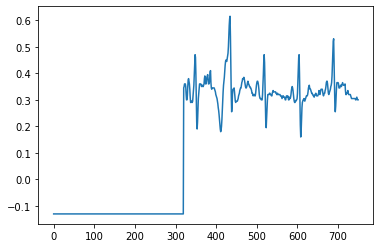

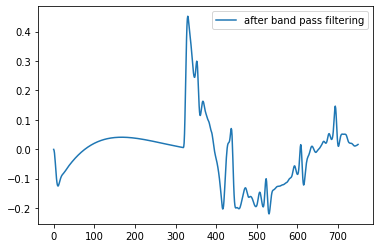

In [0]:
plt.plot(raw_ECG_signals[2][:750],label="before band pass filtering")
plt.figure()
plt.plot(bf_ECG_signals[2][:750], label="after band pass filtering")
plt.legend()

###4.1.3 Hampel filter

In [0]:
def hampel_filter_forloop(input_series, window_size, n_sigmas=3):
    
    n = len(input_series)
    new_series = input_series.copy()
    k = 1.4826 # scale factor for Gaussian distribution
    
    indices = []
    
    # possibly use np.nanmedian 
    for i in range((window_size),(n - window_size)):
        x0 = np.median(input_series[(i - window_size):(i + window_size)])
        S0 = k * np.median(np.abs(input_series[(i - window_size):(i + window_size)] - x0))
        if (np.abs(input_series[i] - x0) > n_sigmas * S0):
            new_series[i] = x0
            indices.append(i)
    
    return new_series, indices

In [0]:
hf_ECG_signals=[]
for i in range(len(bf_ECG_signals)):
  print("hampel filering for", i+1, "th sample...")
  hf_ECG_signal, _ = hampel_filter_forloop(bf_ECG_signals[i], 10)
  hf_ECG_signals.append(hf_ECG_signal)
print("After Hample filtering, there are:", len(hf_ECG_signals), "records")

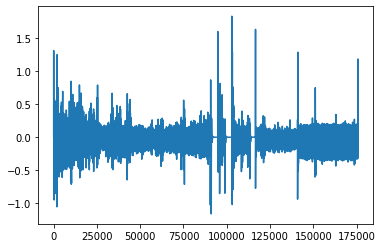

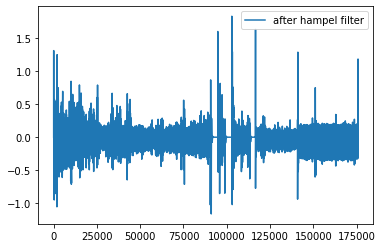

In [0]:
plt.plot(hf_ECG_signals[1], label = "before hampel filter")
plt.figure()
plt.plot(bf_ECG_signals[1], label = "after hampel filter")
plt.legend()

In [0]:
with open('D:WFDB/matched/filtered_ECG_signals_p09.pkl', "wb") as fp:
  pickle.dump(bf_ECG_signals, fp)

In [0]:
with open('D:WFDB/matched/filtered_ECG_signals_p09.pkl', "rb") as fp:
  bf_ECG_signals = pickle.load(fp)

### 4.1.4 Segmentation

In [0]:
def generate_segment_data(source,seg_len):
  n=0
  signals =[]
  for signal in source:
    for i in range(int(len(signal)/seg_len)):
      seg = signal[seg_len*i:seg_len*(i+1)]
      signals.append(seg)
    n+=1
#convert list into a numpy array and change its dim from (num of records, seg_len, 1) to (num of records, seg_len)
  signals = np.asarray(list(map(lambda x: np.reshape(x,3750),signals)))

  return signals

In [0]:
signals = generate_segment_data(bf_ECG_signals, 3750)
print('signals dim:', signals.shape)
signals = np.expand_dims(signals, axis=1)
signals = np.expand_dims(signals,axis=3)
print('signals dim after resize', signals.shape)

signals dim: (83197, 3750)
signals dim after resize (83197, 1, 3750, 1)


###4.1.5 Normalization

In [0]:
#normalization
signals = sklearn.preprocessing.scale(signals)

##4.2 Other optional filters and processing algorithms

### 4.2.1 Resample ECG signals

Only resample the WFDB ECG if the Deep_ECG model is based on a frequency other than 125Hz

In [0]:
from wfdb import processing
resamp_ECG_signals = []
for i in range(len(ECG_signals)):
  resamp_ECG_signal, _ = wfdb.processing.resample_sig(raw_ECG_signals[i],125,300)
  resamp_ECG_signals.append(new_ECG_signal)

In [0]:
plt.plot(resamp_ECG_signals[1][:432]*-1,label = "300Hz")
plt.figure()
plt.plot(raw_ECG_signals[1][:180]*-1, label="125Hz")
plt.legend()

In [0]:
with open('D:/WFDB/matched/ECG_signals_300HZ.pkl', "wb") as fp:
  pickle.dump(resamp_ECG_signals, fp)

In [0]:
with open('D:/WFDB/matched/ECG_signals_300HZ.pkl', "rb") as fp:
  resamp_ECG_signals = pickle.load(fp)

###4.2.2 Flip ECG signals

Only flip ECG signals if it was recorded in the reverse way

In [0]:
rev_ECG_signals = np.multiply(raw_ECG_signals, -1)

In [0]:
print("After flipping signals, there are:", len(rev_ECG_signals), "records")

After flipping signals, there are: 417 records


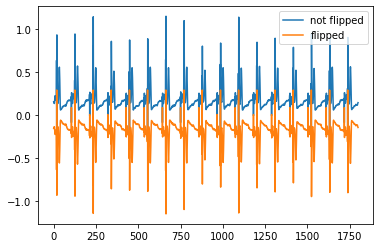

In [0]:
plt.plot(raw_ECG_signals[0][:1800],label ="not flipped")
plt.plot(rev_ECG_signals[0][:1800], label="flipped")
plt.legend()

### 4.2.3 Flat peak removal

Use flat peak removal for ABP waveform, since it is the ground truth for blood pressure; it is not necessary to use it here.

# 5.Predict Afib using ECG signal

In [0]:
#load model
os.chdir(r"C:\Users\57lzhang.US04WW4008\Desktop\Afib\Afib_ECG data")
model = tf.keras.models.load_model('Deep_ECG.h5')

In [0]:
prediction = model.predict(signals)

In [0]:
threshold = 0.5
pred = np.where(prediction > threshold, 1, 0)

In [0]:
unique,counts=np.unique(pred, return_counts=True)
print('There are', counts[0], 'Non-Afib')
print('There are', counts[1], 'Afib')

There are 79228 Non-Afib
There are 3969 Afib


In [0]:
np.savetxt('ECG_Afib_labels_p09.csv',pred,fmt='%1.0f')

#6.Process PPG data

In [0]:
with open('D:WFDB//matched/PPG_signals_p09.pkl', "rb") as fp:
  raw_PPG_signals = pickle.load(fp)

##6.1 Resample PPG signals

In [0]:
#use wfdb.resample
from wfdb import processing
resamp_PPG_signals = []
for i in range(len(ECG_signals)):
  resamp_PPG_signal, _ = wfdb.processing.resample_sig(raw_PPG_signals[i],125,300)
  resamp_PPG_signals.append(new_PPG_signal)
#apply filters before using DEEP-ECG to label it

In [0]:
plt.plot(resamp_PPG_signals[1][:180]*-1,label = "300Hz")
plt.plot(raw_PPG_signals[1][:180]*-1, label="125Hz")
plt.legend()

##6.2 Flip PPG signals

In [0]:
rev_PPG_signals = np.multiply(resamp_PPG_signals, -1)

In [0]:
print("After band pass filtering, there are:", len(rev_PPG_signals), "records")

In [0]:
plt.plot(resamp_PPG_signals[1][:180]*-1,label = "not flipped")
plt.plot(rev_PPG_signals[1][:180]*-1, label="flipped")
plt.legend()

## 6.3 Band pass filter

In [0]:
bf_PPG_signals = []
for i in range(len(raw_PPG_signals)):
  bf_PPG_signal =butter_bandpass_filter(raw_PPG_signals[i],0.2,8,300,order=3)
  bf_PPG_signals.append(bf_PPG_signal)
print("After band pass filtering, there are:", len(bf_PPG_signals), "records")

After band pass filtering, there are: 417 records


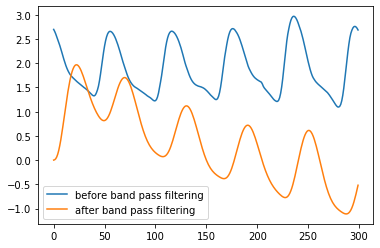

In [0]:
plt.plot(raw_PPG_signals[1][:300],label="before band pass filtering")
plt.plot(bf_PPG_signals[1][:300], label="after band pass filtering")
plt.legend()

##6.4 Normalization

##6.5 Hampel filter

In [0]:
hf_PPG_signals=[]
for i in range(len(bf_PPG_signals)):
  print("band pass filering at", i+1, "th sample...")
  hf_PPG_signal, _ = hampel_filter_forloop(bf_PPG_signals[i], 10)
  hf_PPG_signals.append(hf_PPG_signal)
print("After Hample filtering, there are:", len(hf_PPG_signals), "records")

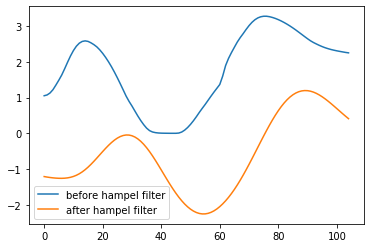

In [0]:
plt.plot(raw_PPG_signals[1][400:505], label = "before hampel filter")
plt.plot(bf_PPG_signals[1][400:505], label = "after hampel filter")
plt.legend()

## 6.6 Flat line and peak removal

##6.7 Segmentaion

In [0]:
signals = generate_segment_data(bf_PPG_signals, 3750)
print('signals dim:', signals.shape)
signals = np.expand_dims(signals, axis=1)
signals = np.expand_dims(signals,axis=3)
print('signals dim after resize', signals.shape)

signals dim: (83197, 3750)
signals dim after resize (83197, 1, 3750, 1)


In [0]:
#save segmented PPG signal
with open('D:WFDB//matched/seg_PPG_signals_p09.pkl', "wb") as fp:
  pickle.dump(signals, fp)